<center>
    <img width='80%' src='https://www.dropbox.com/s/papewf5j4ikoykt/rapids_workflow.png?dl=1'></center>    


<h1>RAPIDS Demo - End-To-End ML Workflow</h1>

> 0. motivate rapids [ show coverage of modern data science tools ]

> 1. generate a synthetic dataset ( with optional noise, missing data, and outliers)    
    * synthetic : sklearn.datasets
    * mini-real : mnist/fashion-mnist
    * real-dataset : uber, walmart, criteo
    
> 2. go through a supervised machine learning data science workflow
    * ingest data [ csv read ]
    * [ TODO ] repair data [ missing data, outliers ]    
    * rescale data [ standard scaler ]
    * [ TODO ] feature engineer [ cross-correlation, dimensionality reduction ]
    * train classifier [ xgboosg ]
    * evaluate
    * optional [ create a model ensemble ]

> 3. discuss scoring/inference    
    * rapids ngc container


In [1]:
import pandas as pd, numpy as np, sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, accuracy_score

import xgboost
from xgboost import plot_tree

import cuml, cudf, numba, scipy, cupy
from numba import cuda 

import ipyvolume as ipv
import matplotlib.pyplot as plt
from fig_helpers import *

# Motivation: coverage of modern data science tools

In [2]:
schemaFilePath = '/rapids/notebooks/kaggle_data/schema.csv'
schemaSurveyDF = pd.read_csv(schemaFilePath)

In [3]:
scrapedKernelMethodFilePath = '/rapids/notebooks/kaggle_data/results.csv'
kaggleKernelMethodsDF = pd.read_csv(scrapedKernelMethodFilePath)

In [4]:
surveyFilePath = '/rapids/notebooks/kaggle_data/multipleChoiceResponses.csv'
kaggleSurveyDF = pd.read_csv(surveyFilePath, encoding="ISO-8859-1", low_memory=False)

	 At work, on average, what percentage of your time is devoted to:  
	 -  Gathering and cleaning data
	 -  Model building/model selection
	 -  Putting your work into production
	 -  Visualizing data
	 -  Finding insights in the data and communicating these to relevant stakeholders


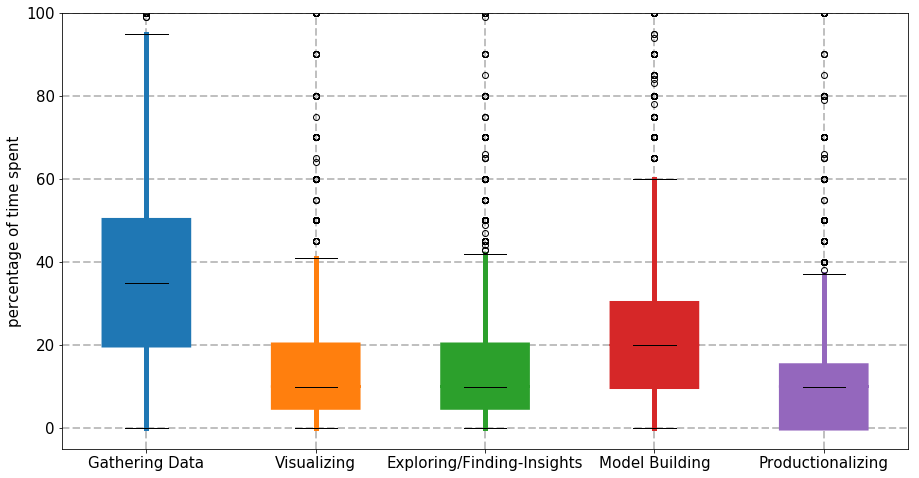

In [5]:
set_rcParams(); plot_datascientist_time_breakdown(kaggleSurveyDF, schemaSurveyDF)

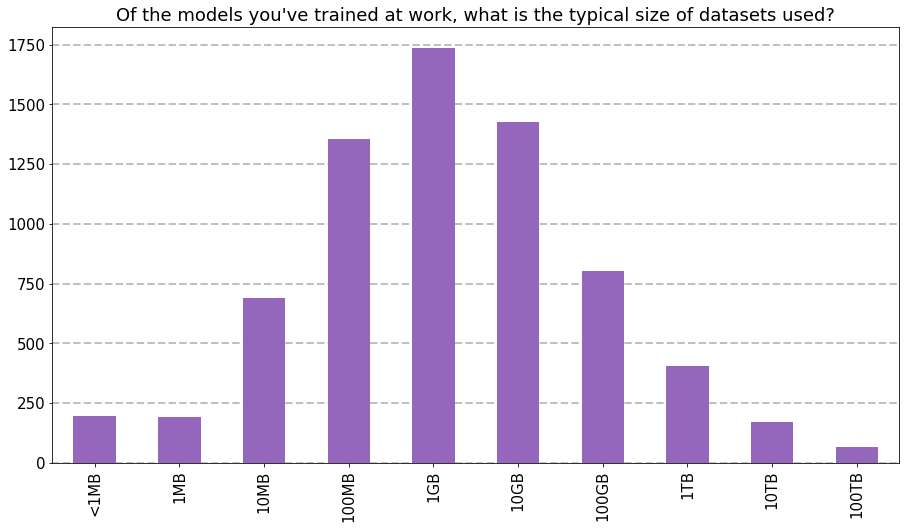

In [6]:
qNum = 119; 
bar_plot_question(kaggleSurveyDF, schemaSurveyDF, qNum, nTopResults = 10, newIndex = ['<1MB', '1MB', '10MB', '100MB','1GB', '10GB',  '100GB', '1TB', '10TB', '100TB'])

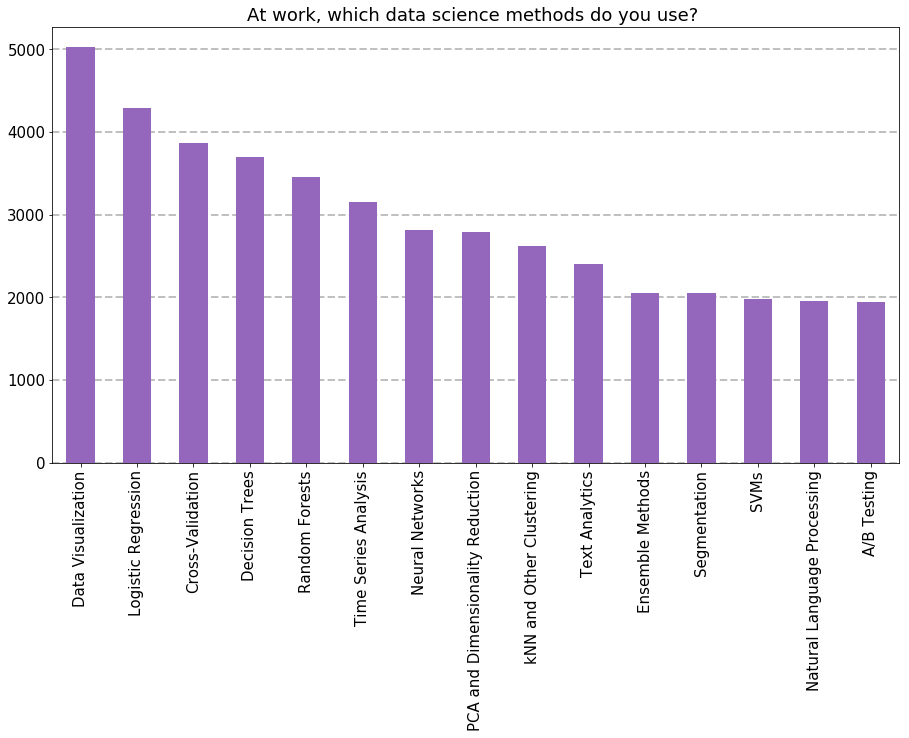

In [7]:
qNum = 180; 
bar_plot_question(kaggleSurveyDF, schemaSurveyDF, qNum, 15)

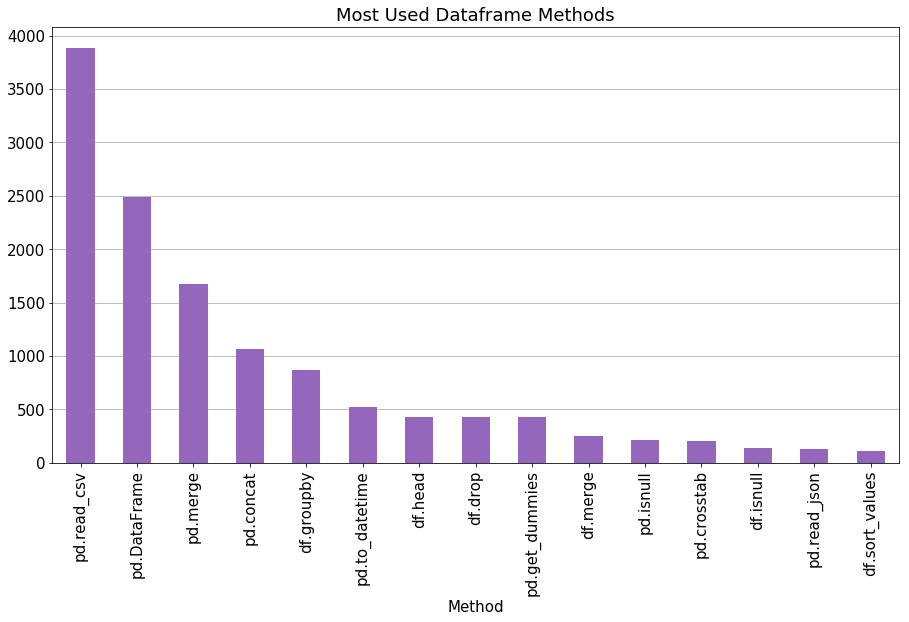

In [8]:
kaggleKernelMethodsDF.index = kaggleKernelMethodsDF['Method']
kaggleKernelMethodsDF.head(15).plot.bar(legend=False, alpha=1, color='tab:purple', rot=90); plt.gca().set_axisbelow(True); plt.gca().yaxis.grid(True)
plt.title('Most Used Dataframe Methods');

# hyperparms

In [9]:
nSamples = 100000

# generate datasets

In [125]:
%%time
nClusters = 5
blobsDataset = datasets.make_blobs( n_samples = nSamples, 
                                    centers = nClusters, 
                                    n_features = 3, 
                                    cluster_std = 0.25, 
                                    random_state = 0)[0]

moonsDataset = datasets.make_moons(n_samples = nSamples, noise = 0)[0]
moonsDataset = np.hstack( [moonsDataset, np.zeros( (moonsDataset.shape[0], 1) )] )*5

swissRollDataset = datasets.make_swiss_roll( n_samples = nSamples, noise = .005)[0]

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 102 ms


# augment dataset with labels of the three datasets

| <h1>dataset</h1> | <h1> class label</h1> |
| --- | --- | 
| <h3>blobs</h3> | <h3>0</h3> |
| <h3>moons</h3> | <h3>1</h3> |
| <h3>swissRoll</h3>| <h3>2</h3> |


In [126]:
blobsLabels = np.zeros(blobsDataset.shape[0])
moonsLabels = 1 * np.ones(moonsDataset.shape[0])
sRollLabels = 2 * np.ones(swissRollDataset.shape[0])

In [127]:
%%time
X = np.vstack([blobsDataset, moonsDataset, swissRollDataset])
y = classificationLabels = np.hstack( [blobsLabels, moonsLabels, sRollLabels] )

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 3.32 ms


In [128]:
X.shape, y.shape

((300000, 3), (300000,))

In [129]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.10, random_state = 42)

## plot

In [132]:
data  = np.vstack( [X_train, X_test] )
colorStack = np.vstack( [ np.ones_like(X_train) * [102, 51, 153]/255,
                          np.ones_like(X_test) * [255, 255, 0]/255 ] )

In [133]:
ipv.quickscatter( data[:, 0], data[:, 1], data[:, 2], size = 1, marker = 'sphere', color = colorStack)

In [134]:
data = moonsDataset
ipv.quickscatter( data[:, 0], data[:, 1], data[:, 2], size = .5, marker = 'sphere', color = 'purple')

In [135]:
data = blobsDataset
ipv.quickscatter( data[:, 0], data[:, 1], data[:, 2], size = .5, marker = 'sphere', color = 'purple')

In [136]:
data = swissRollDataset
ipv.quickscatter( data[:, 0], data[:, 1], data[:, 2], size = .5, marker = 'sphere', color = 'purple')

### write to CSV

In [137]:
%%time
pd.DataFrame(data = X_train).to_csv('X_train.csv.txt', index = False)
pd.DataFrame(data = X_test).to_csv('X_test.csv.txt', index = False)
pd.DataFrame(data = y_train).to_csv('y_train.csv.txt', index = False)
pd.DataFrame(data = y_test).to_csv('y_test.csv.txt', index = False)

CPU times: user 2.14 s, sys: 24 ms, total: 2.17 s
Wall time: 2.16 s


In [138]:
!du -h *csv.txt

1.5M	X_test.csv.txt
14M	X_train.csv.txt
120K	y_test.csv.txt
1.1M	y_train.csv.txt


# load csv

In [139]:
%%time 
pd_X_train = pd.read_csv('X_train.csv.txt',  delimiter=',')
pd_X_test = pd.read_csv('X_test.csv.txt',  delimiter=',')
pd_y_train = pd.read_csv('y_train.csv.txt',  delimiter=',')
pd_y_test = pd.read_csv('y_test.csv.txt',  delimiter=',')

CPU times: user 260 ms, sys: 24 ms, total: 284 ms
Wall time: 284 ms


In [140]:
# get column-names
f = open('X_train.csv.txt'); colNames = f.readline().strip().split(','); f.close()

In [141]:
%%time
cudf_X_train = cudf.read_csv('X_train.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float32', 'float32', 'float32'])
cudf_X_test = cudf.read_csv('X_test.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float32', 'float32', 'float32'])
cudf_y_train = cudf.read_csv('y_train.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float32', 'float32', 'float32'])
cudf_y_test = cudf.read_csv('y_test.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float32', 'float32', 'float32'])

CPU times: user 36 ms, sys: 12 ms, total: 48 ms
Wall time: 45.8 ms


In [142]:
# evaluate speedup

# normalize [ apply rows ] [ X ] 
> compute train stats and apply to test data

In [143]:
%%time 
scaler = sklearn.preprocessing.StandardScaler().fit(pd_X_train) # normalize
pd_X_train = scaler.transform(pd_X_train)
pd_X_test = scaler.transform(pd_X_test)

CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 31.5 ms


In [144]:
@cuda.jit 
def gpu_scale(outputCol, colGPUArrays, colMeans, colStDevs):
    iRow = cuda.grid(1)
    if iRow < colGPUArrays.size:
        outputCol[iRow] = ( colGPUArrays[iRow] - colMeans ) / ( colStDevs + 1e-10 )

In [145]:
def standard_scaler_numba( targetDF, trainMeans = None, trainStdevs = None):
    nRows = targetDF.shape[0]
    
    blockSize = 128
    blockCount = nRows // blockSize + 1
    scaledDF = cudf.DataFrame()
    
    if trainMeans is None and trainStdevs is None:
        trainMeans = {}
        trainStdevs = {}
        
    for iColName in targetDF.columns:
        colGPUArray = targetDF[iColName].to_gpu_array()
        outputCol = cuda.device_array ( shape=(nRows), dtype=colGPUArray.dtype.name)       
        if iColName not in trainMeans.keys():
            trainMeans[iColName] = targetDF[iColName].mean()
        if iColName not in trainStdevs.keys():
            trainStdevs[iColName] = targetDF[iColName].std()
        gpu_scale[(blockCount),(blockSize)](outputCol, colGPUArray, trainMeans[iColName], trainStdevs[iColName])
        scaledDF.add_column(name=iColName, data = outputCol)    
        
    return scaledDF, trainMeans, trainStdevs

In [146]:
_, _, _ = standard_scaler_numba( cudf_X_test.copy().head(2) ) # warmup

In [147]:
%%time
cudf_X_train, trainMeans, trainStdevs = standard_scaler_numba( cudf_X_train )
cudf_X_test, _, _ = standard_scaler_numba( cudf_X_test, trainMeans, trainStdevs )

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 48 ms


# verify numerical equivalence (approximate)

In [148]:
trainMeans, scaler.mean_, trainStdevs, scaler.scale_

({'0': 1.4889885416666666, '1': 5.57935, '2': 0.4946375578703704},
 array([1.48732165, 5.57929355, 0.49464442]),
 {'0': 4.77765526184304, '1': 5.747861323335864, '2': 5.244041846432739},
 array([4.77705911, 5.74788009, 5.24403038]))

In [149]:
print(cudf_X_test.head(2))

             0          1         2
0   -0.1577824 -0.3010275 0.2663291
1 -0.032342114 -1.1792339 0.4071439


In [150]:
print(pd_X_test[0:2,:])

[[-0.15745315 -0.30101671  0.26632837]
 [-0.03199717 -1.17922017  0.4071435 ]]


-----
# classification -- xgboost [ X ]
-----
>XGBoost is a popular algorithm for classification. It uses a sequence of decision trees built in succession such that each new tree attempts to correct the errors made by its predecessors (analogy to multiple golf swings [ each improving on the past ] to reach a target).

<img src='https://www.dropbox.com/s/vcqjocjj9w5ifvc/xgboost.png?dl=1' width =90%>

# prepare data for training

In [151]:
X = pd_X_train
y = pd_y_train

In [152]:
X_gpu = xgboost.DMatrix(pd_X_train, label=np.squeeze(pd_y_train))
y_gpu = xgboost.DMatrix(pd_X_test, label=np.squeeze(pd_y_test))

### specify parameters

noteable parameters: [ to see all available options execute '?xgboost.XGBClassifier' in a new cell] 

* __max_depth__ : int [ default = 3 ] -- Maximum tree depth for base learners.
* __n_estimators__ : int [ default = 100 ] -- Number of boosted trees to fit.
* __n_jobs__ : int [ default = 1 ] -- Number of parallel threads used to run xgboost.

In [153]:
maxDepth = 3
nTrees = 50

paramsGPU = {
    'max_depth': 8,
    'nround': nTrees*4,
    'n_gpus': 1,
    'tree_method': 'gpu_hist',
    'objective': 'gpu:reg:linear', 
    'random_state': 1,
    'verbose': True
}
paramsCPU = {
    'max_depth': maxDepth,
    'nround': nTrees,
    'objective': 'binary:logistic',
}

# train on cpu

In [154]:
xgBoostModelCPU = xgboost.XGBClassifier(max_depth = maxDepth, n_estimators = nTrees, objective = paramsCPU['objective'])

In [155]:
%%time
xgBoostModelCPU.fit( X, np.squeeze(y) );

CPU times: user 14.3 s, sys: 0 ns, total: 14.3 s
Wall time: 14.3 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# train on GPU

In [156]:
%%time 
xgBoostModelGPU = xgboost.train( dtrain = X_gpu, params = paramsGPU)

CPU times: user 104 ms, sys: 24 ms, total: 128 ms
Wall time: 146 ms


In [157]:
# compute speedup

## infer/predict using trained [CPU ] model

In [158]:
%%time
yPredTrain = xgBoostModelCPU.predict(pd_X_train)
yPredTest = xgBoostModelCPU.predict(pd_X_test)

CPU times: user 1.42 s, sys: 12 ms, total: 1.43 s
Wall time: 1.43 s


## infer/predict using trained [GPU ] model
> note that our objective was changed to a regression [ gpu accelerated ] so we must take care to convert each of our predictions from a continuous value to a discrete class (essentially by rounding).

In [159]:
# convert continuous prediction to a multi-class option
def continuous_to_discrete( data, nClasses = 3):
    data[data>nClasses-1] = nClasses-1 # filter values beyond the possible classes
    return np.abs(np.round(data))

In [160]:
%%time
yPredTrain_GPU = continuous_to_discrete ( xgBoostModelGPU.predict(X_gpu) )
yPredTest_GPU = continuous_to_discrete ( xgBoostModelGPU.predict(y_gpu) )

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.02 ms


In [161]:
# compute speedup

## evaluate performance

In [162]:
print( 'CPU test accuracy: {0:.5f} '.format( accuracy_score(pd_y_test, yPredTest) ))
print( 'GPU test accuracy: {0:.5f} '.format( accuracy_score(pd_y_test, yPredTest_GPU) ))

CPU test accuracy: 0.99227 
GPU test accuracy: 0.99963 


TODO: to increase model accuracy, increase complexity, number of trees, max_depth


In [163]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrain))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTest))


 confusion matrix on TRAIN data -- 
[[90017     0    24]
 [    0 90030     0]
 [ 1804     0 88125]]

 confusion matrix on TEST data -- 
[[9956    0    3]
 [   0 9970    0]
 [ 229    0 9842]]


In [164]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrain_GPU))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTest_GPU))


 confusion matrix on TRAIN data -- 
[[90010    26     5]
 [    0 90030     0]
 [    1    40 89888]]

 confusion matrix on TEST data -- 
[[ 9951     4     4]
 [    0  9970     0]
 [    0     3 10068]]


# visualize trees

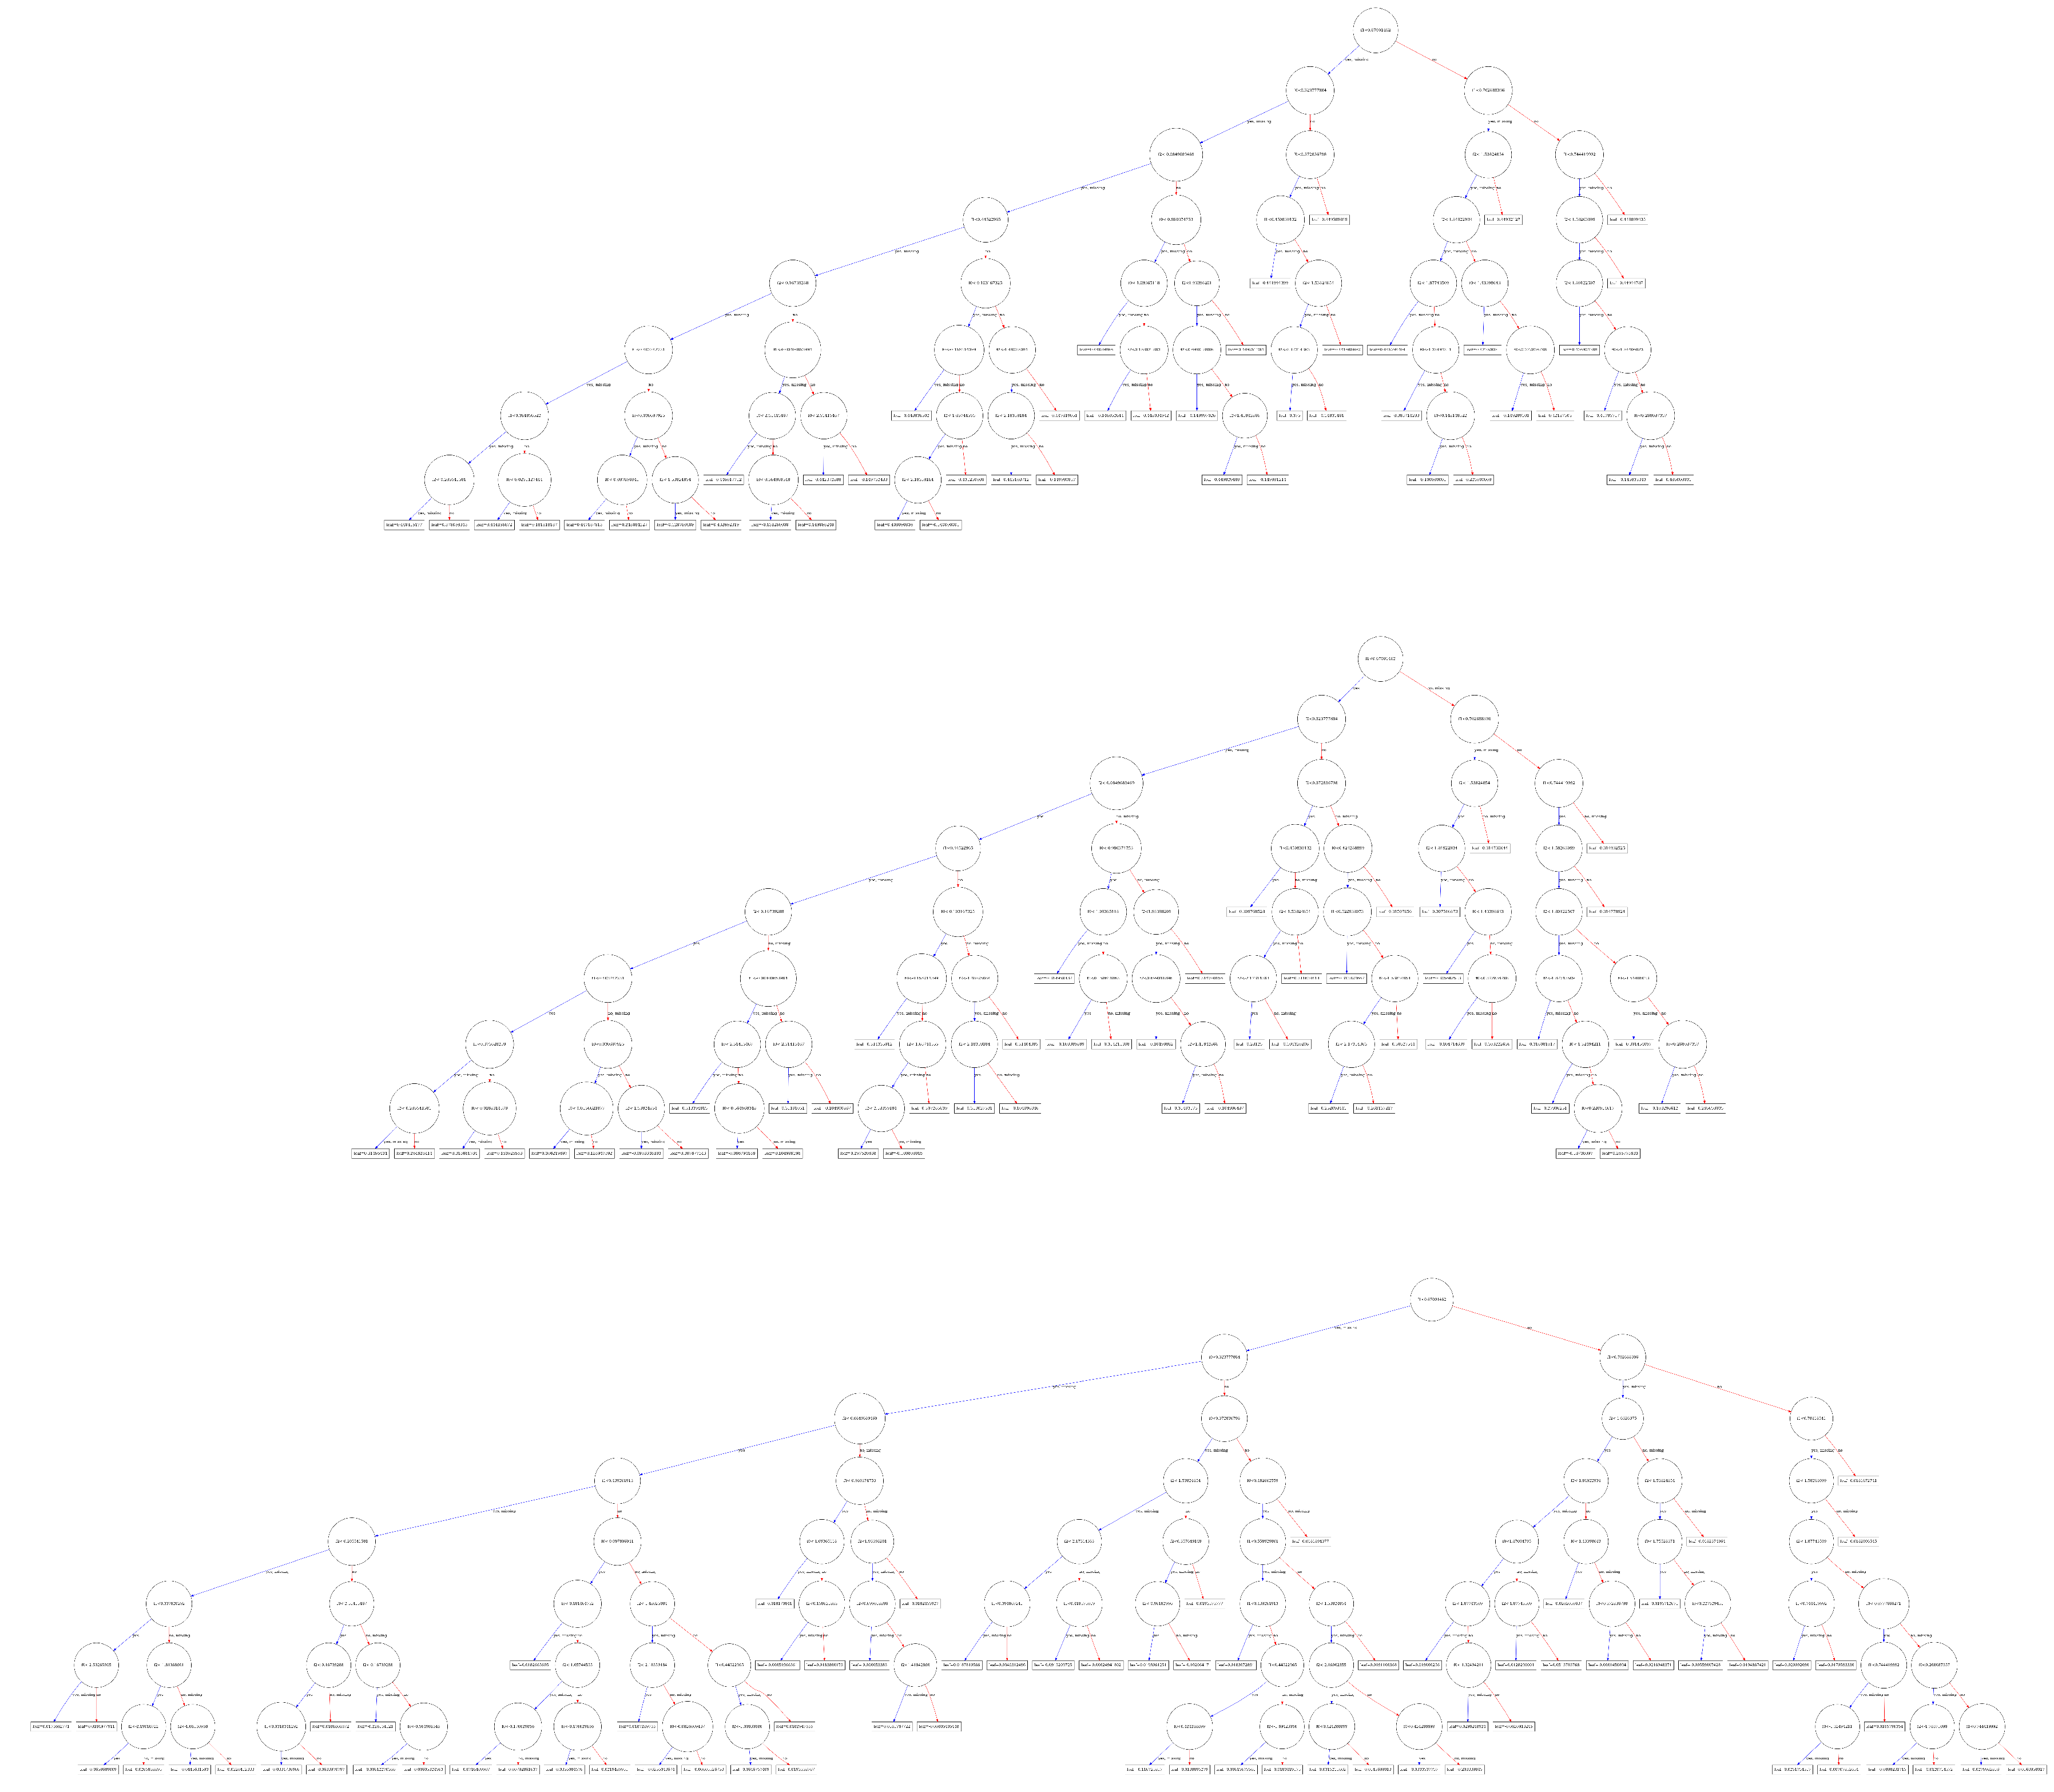

In [49]:
fig = plt.figure(figsize=(50,50))
plot_tree(xgBoostModelGPU, num_trees=0, ax=plt.subplot(3,1,1))
plot_tree(xgBoostModelGPU, num_trees=1, ax=plt.subplot(3,1,2))
plot_tree(xgBoostModelGPU, num_trees=xgBoostModelGPU.best_ntree_limit-1, ax=plt.subplot(3,1,3))

## visualize predictions

In [165]:
# consider building a numba kernel here ? 
def map_colors_to_clusters_topK ( dataset, labels, topK=None, cmapName = 'tab10'):
    if topK == None:
        topK = dataset.shape[0]
    
    colorStack = np.zeros((topK, 3), dtype=np.float32)
    
    cMap = plt.get_cmap(cmapName)
    for iColor in range ( topK ):
        colorStack[iColor] = cMap.colors[ labels[iColor] ]
        
    return colorStack    

In [166]:
def colored_topK ( dataset, topK = None):    
    if topK == None:
        topK == dataset.shape[0]
        
    return lambda dataset, colorStack, topK : ipv.quickscatter( dataset[0:topK, 0], 
                                                                dataset[0:topK, 1], 
                                                                dataset[0:topK, 2], 
                                                                size = .5, marker = 'sphere', 
                                                                color = colorStack)      

In [167]:
colorStackClassifier = map_colors_to_clusters_topK ( pd_X_test, yPredTest_GPU.astype(np.int), topK=None )

In [168]:
ipv.quickscatter( pd_X_test[:, 0], pd_X_test[:, 1], pd_X_test[:, 2], 
                  size = 1, marker = 'sphere', 
                  color = colorStackClassifier)

-------
# appendix
-------

# extension 1 : hyper-parameter search

# extension 2 : model ensemble ( xgboost + clustering )

<img width='95%' src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png'>

### sklearn-clustering

In [169]:
%%time
dbScanModel = DBSCAN( min_samples = 10 ).fit(pd_X_test)
labels = dbScanModel.labels_
np.array(np.unique(labels, return_counts=True)).T

CPU times: user 1.76 s, sys: 232 ms, total: 1.99 s
Wall time: 1.99 s


### cuml-clustering

In [173]:
%%time
clustering_cuml = cuml.DBSCAN( eps = .15 , min_samples = 100 )
clustering_cuml.fit( cudf_X_test )

n_rows: 30000
0x7f4b33adc200
CPU times: user 528 ms, sys: 188 ms, total: 716 ms
Wall time: 715 ms


In [174]:
%%time
print( clustering_cuml.labels_.value_counts() )

       
4 12018
3  7055
2  4950
0  2027
5  1991
1  1948
-1    11
CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 22.7 ms


# map clusters to colors

In [175]:
%%time
topK = None
colorStack = map_colors_to_clusters_topK( pd_X_test, clustering_cuml.labels_, topK  )

CPU times: user 3.67 s, sys: 20 ms, total: 3.69 s
Wall time: 3.69 s


# plot colored clusters

In [176]:
colored_topK( pd_X_test, topK )(pd_X_test, colorStack, topK)

# end [ thanks! ]

please provide feedback/suggestions and errata @ https://github.com/rapidsai/notebooks